In [51]:
import numpy as np
import json
import pandas as pd
from utils import Timer
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import traj_dist.distance as tdist
from parameters import *
import numpy as np


#### 读取数据


In [52]:
timer = Timer()

file_path = "data/full/gps_20161101"
dict_path = "data/str_grid2idx_400_44612.json"
nrows = 1000000
vocab_size = 400


# read data
timer.tik("read data")
df = pd.DataFrame(pd.read_csv(file_path, header=None, nrows=nrows))
df.columns = ["name", "id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))


read data start
read data/full/gps_20161101 done, 0.73s after read data start


0.7297332286834717

#### 去除超出范围的数据点


In [53]:
pad = 0.002


l = len(df)
df = df[(df["lon"] > 104.04214 + pad) & (df["lon"] < 104.12958 - pad)]
df = df[(df["lat"] > 30.65294 + pad) & (df["lat"] < 30.72775 - pad)]
print(f"剩{len(df)}/{l}个点，筛掉{round(100 - 100 * len(df) / l)}%")


剩948146/1000000个点，筛掉5%


#### GroupBy转换为1维点列

In [54]:
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok(f"load dict{dict_path}")


def group_concat(group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d = t2g.convert1d(origin_traj)
    series = pd.Series({
        "origin_trajs": origin_traj,
        "trajs": traj_1d,
        "origin_len": len(origin_traj),
        "len": len(traj_1d),
        "max_lon": group["lon"].max(),
        "max_lat": group["lat"].max(),
        "min_lon": group["lon"].min(),
        "min_lat": group["lat"].min(),
    })
    return series


# group-apply
res = Parallel(n_jobs=44)(delayed(group_concat)(group)for name, group in df.groupby("id"))
df = pd.DataFrame(res)
timer.tok("group-apply")


load dictdata/str_grid2idx_400_44612.json done, 1.455s after read data start
group-apply done, 32.115s after read data start


32.11460018157959

##### 看看数据情况

count    5485.000000
mean      103.222060
std        72.892705
min         1.000000
25%        47.000000
50%        92.000000
75%       144.000000
max       583.000000
Name: len, dtype: float64

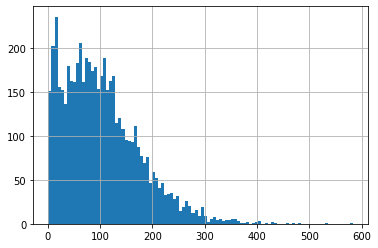

In [55]:
df['len'].hist(bins=100)
df['len'].describe()

#### 过滤过长过短轨迹

In [56]:
dff = df[(df["len"] > 10) & (df["len"] < 256)]
print(f"剩{len(dff)}/{len(df)}条轨迹，筛掉{round(100 - 100 * len(dff) / len(df))}%")


剩5006/5485条轨迹，筛掉9%


#### 生成pair-wise轨迹距离矩阵


In [57]:
# dff = dff.reset_index()
origin_trajs = dff["origin_trajs"].to_list()
arr = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr)
dis_matrix = np.zeros((length, length))
dis_func = getattr(tdist, "discret_frechet")


def cal_dis(i, j, x, y, n):
    dis = dis_func(x, y)
    if i == j + 1 and i % 100 == 1:
        timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
    return i, j, dis

res = Parallel(n_jobs=44)(
    delayed(cal_dis)(i, j, arr[i], arr[j], length - 1) for i in range(length) for j in range(i))
timer.tok("calculate distance")
for (i, j, dis) in res:
    dis_matrix[i,j] = dis
    dis_matrix[j,i] = dis


1-0.0% done, 33.005s after read data start
101-0.04% done, 33.577s after read data start
201-0.16% done, 34.576s after read data start
301-0.36% done, 36.277s after read data start
401-0.64% done, 38.826s after read data start
501-1.0% done, 42.082s after read data start
601-1.44% done, 46.751s after read data start
701-1.96% done, 51.857s after read data start
801-2.56% done, 57.418s after read data start
901-3.24% done, 63.74s after read data start
1001-4.0% done, 70.765s after read data start
1101-4.84% done, 76.315s after read data start
1201-5.76% done, 84.788s after read data start
1301-6.76% done, 92.904s after read data start
1401-7.84% done, 101.925s after read data start
1501-8.99% done, 110.638s after read data start
1601-10.23% done, 120.424s after read data start
1701-11.55% done, 131.297s after read data start
1801-12.95% done, 141.804s after read data start
1901-14.43% done, 153.549s after read data start
2001-15.98% done, 166.605s after read data start
2101-17.62% done,

#### 生成 Train Dataset 第六步：保存

In [58]:
full = True
file_name = file_path.split("/")[-1]
save_path = "data/test/"
file_path = save_path + file_name
sorted_index = np.argsort(dis_matrix, axis=1)
dict_save = {'trajs': dff["trajs"].to_list(), "sorted_index": sorted_index.tolist(), 'origin_trajs': origin_trajs}
if full:
    dict_save["dis_matrix"] = dis_matrix.tolist()
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_{vocab_size}_dataset_full.json", "w"))
else:
    json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_{vocab_size}_dataset_small.json", "w"))
timer.tok("save")


save done, 916.643s after read data start


916.6428894996643